# P300 Starter Notebook

This notebook demonstrates a minimal P300 analysis pipeline using synthetic data.

In [1]:
import matplotlib.pyplot as plt
import mne
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score

print("MNE", mne.__version__)

MNE 1.9.0


## Generate synthetic P300-like data
We create 1 minute of 8-channel EEG sampled at 256 Hz with random noise. Target events have a simulated P300 response around 300 ms.

In [2]:
sfreq = 256
ch_names = ["Fz", "Cz", "Pz", "Oz", "P3", "P4", "C3", "C4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types="eeg")
duration = 60  # seconds
n_samples = sfreq * duration
np.random.seed(42)
raw_data = 1e-6 * np.random.randn(len(ch_names), n_samples)  # V
raw = mne.io.RawArray(raw_data, info)

n_target = 20
n_nontarget = 120
all_times = np.random.choice(
    np.arange(sfreq, n_samples - sfreq), n_target + n_nontarget, replace=False
)
event_id = dict(target=1, nontarget=2)
labels = np.array([1] * n_target + [2] * n_nontarget)
np.random.shuffle(labels)
# ensure time order
events = np.column_stack([all_times, np.zeros_like(all_times), labels])

amplitudes = np.linspace(5e-6, 1e-6, len(ch_names))[:, None]
width = int(0.1 * sfreq)
gaussian = np.exp(-0.5 * ((np.arange(width) - width // 2) / (0.05 * sfreq)) ** 2)
for ev_time, label in zip(all_times, labels):
    if label == 1:
        start = ev_time + int(0.3 * sfreq) - width // 2
        if start < 0 or start + width > n_samples:
            continue
        raw._data[:, start : start + width] += amplitudes * gaussian

Creating RawArray with float64 data, n_channels=8, n_times=15360
    Range : 0 ... 15359 =      0.000 ...    59.996 secs
Ready.


## Preprocess
Band-pass filter and down-sample to 128 Hz.

In [3]:
raw.filter(0.1, 30, fir_design="firwin")
raw.resample(128)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8449 samples (33.004 s)



[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


<RawArray | 8 x 7680 (60.0 s), ~491 KiB, data loaded>

## Epoching
Create epochs around each event and baseline correct.

In [4]:
epochs = mne.Epochs(
    raw, events, event_id, tmin=-0.2, tmax=0.8, baseline=(-0.2, 0), preload=True
)

Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 140 events and 129 original time points ...
79 bad epochs dropped


/var/folders/kb/l_0t077x7t770581q_cp3d140000gn/T/ipykernel_49638/1145508065.py:1: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(


## Extract LDA features (250–450 ms)

In [5]:
window = epochs.copy().crop(0.25, 0.45)
X = window.get_data(picks="eeg")
X = X.reshape(len(X), -1)
y = window.events[:, 2]

## Train and evaluate an LDA classifier

In [6]:
cv = StratifiedKFold(5, shuffle=True, random_state=42)
clf = LinearDiscriminantAnalysis()
scores = cross_val_score(clf, X, y, cv=cv)
print(f"LDA mean accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

LDA mean accuracy: 0.886 ± 0.065


## Visualise average ERPs

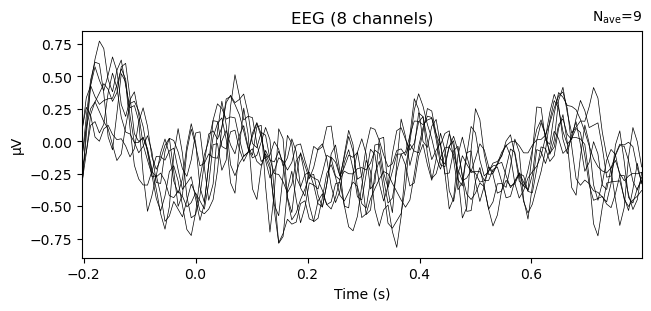

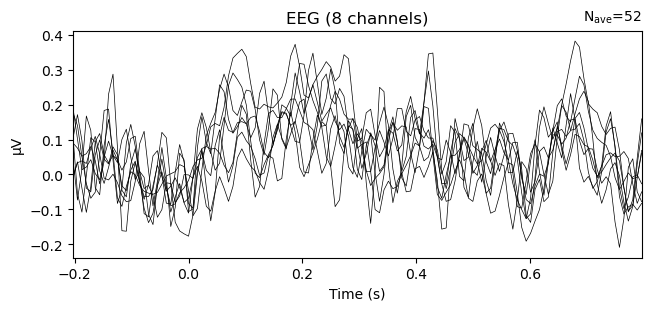

In [12]:
evoked_target = epochs["target"].average()
evoked_nontarget = epochs["nontarget"].average()

fig1 = evoked_target.plot(spatial_colors=False, show=False)
fig2 = evoked_nontarget.plot(spatial_colors=False, show=False)
_ = plt.show() 